In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


In [2]:

# Load the dataset
file_path = "/kaggle/input/monkeypox-patients-dataset/DATA.csv"
df = pd.read_csv(file_path)

# Encode categorical and boolean features
df.fillna("None", inplace=True)
le = LabelEncoder()
df["MonkeyPox"] = le.fit_transform(df["MonkeyPox"])  # Encode target (Positive=1, Negative=0)

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# Convert categorical feature "Systemic Illness" into text format
feature_cols = ["Systemic Illness"] + list(bool_cols)
df["text_features"] = df[feature_cols].astype(str).agg(" ".join, axis=1)

# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text_features"], df["MonkeyPox"], test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


In [3]:

# Use a lightweight and powerful model
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

class MonkeyPoxDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:

# Create datasets and dataloaders
train_dataset = MonkeyPoxDataset(train_texts, train_labels, tokenizer)
val_dataset = MonkeyPoxDataset(val_texts, val_labels, tokenizer)
test_dataset = MonkeyPoxDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)
model.to(device)


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [7]:
 #Freeze all layers except the last 10
for param in model.roberta.encoder.layer[:-10].parameters():
    param.requires_grad = False
for param in model.roberta.encoder.layer[-10:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


In [10]:

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, save_path="/kaggle/working/best_distilbert_model.pth"):
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))
        
        avg_val_loss = evaluate_loss(model, val_loader)
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved to {save_path}")

def evaluate_loss(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Train the model
train_model(model, train_loader, val_loader, optimizer, criterion)

Epoch 1: 100%|██████████| 1094/1094 [03:23<00:00,  5.38it/s, loss=0.615]


Epoch 1, Loss: 0.6146, Val Loss: 0.5988
Best model saved to /kaggle/working/best_distilbert_model.pth


Epoch 2: 100%|██████████| 1094/1094 [03:24<00:00,  5.36it/s, loss=0.604]


Epoch 2, Loss: 0.6043, Val Loss: 0.5895
Best model saved to /kaggle/working/best_distilbert_model.pth


Epoch 3: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.603]


Epoch 3, Loss: 0.6026, Val Loss: 0.5884
Best model saved to /kaggle/working/best_distilbert_model.pth


Epoch 4: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.603]


Epoch 4, Loss: 0.6028, Val Loss: 0.5884


Epoch 5: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.603]


Epoch 5, Loss: 0.6026, Val Loss: 0.5925


Epoch 6: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.601]


Epoch 6, Loss: 0.6006, Val Loss: 0.5878
Best model saved to /kaggle/working/best_distilbert_model.pth


Epoch 7: 100%|██████████| 1094/1094 [03:23<00:00,  5.36it/s, loss=0.601]


Epoch 7, Loss: 0.6009, Val Loss: 0.5881


Epoch 8: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.601]


Epoch 8, Loss: 0.6010, Val Loss: 0.5882


Epoch 9: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.6]  


Epoch 9, Loss: 0.6004, Val Loss: 0.5844
Best model saved to /kaggle/working/best_distilbert_model.pth


Epoch 10: 100%|██████████| 1094/1094 [03:23<00:00,  5.37it/s, loss=0.599]


Epoch 10, Loss: 0.5991, Val Loss: 0.5857


Accuracy: 0.6909
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.31      0.42      1379
           1       0.69      0.91      0.79      2371

    accuracy                           0.69      3750
   macro avg       0.68      0.61      0.61      3750
weighted avg       0.69      0.69      0.65      3750



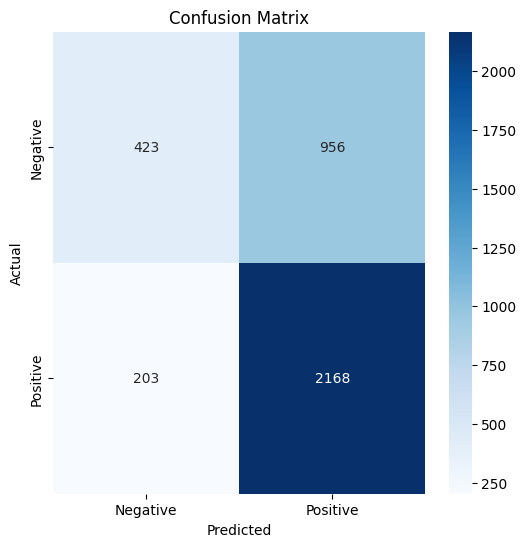

In [11]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(true_labels, predictions))
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model(model, test_loader)
